### Import library

In [676]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
from sklearn import tree
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import KFold
from datetime import datetime as dt
# import seaborn as sns
from IPython.core.display import Image

### Import data
- input data needed
    - obserbed timeseriese data 
    - albedo/tbb timeseriese data

In [677]:
files=['data/April/ground_measure/ts_FREA_H.txt','data/April/satellite/ts_rhop_B01.txt','data/April/satellite/ts_rhop_B02.txt','data/April/satellite/ts_rhop_B03.txt','data/April/satellite/ts_rhop_B04.txt','data/April/satellite/ts_rhop_B05.txt', 'data/April/satellite/ts_rhop_B06.txt', 'data/April/satellite/ts_rhop_B07.txt', 'data/April/satellite/ts_rhop_B08.txt', 'data/April/ground_measure/ts_FREA_extH.txt']

In [678]:
# load files
data = [np.loadtxt(f,delimiter="\t", skiprows=1, dtype={'names':('Time','Value'),'formats':('S18','f8')}) for f in files]

/Users/ojt_camp01/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


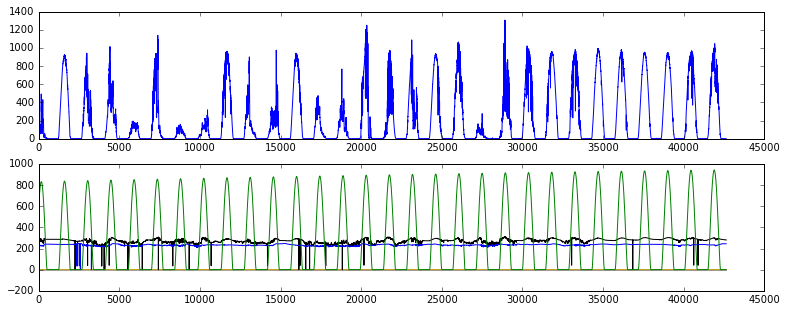

In [679]:
data2 = data
DATA_NUM = len(data)
# plot loaded data
labels = ['B01', 'B02','B05']
plt.figure(figsize=(13, 5))
plt.subplot(2,1,1)
plt.plot(data[0]['Value'],lw=1) # True data
plt.subplot(2,1,2)
[plt.plot(data[i]['Value'], lw=1, ) for i in range(1,DATA_NUM)] # Albedo data
plt.legend()
plt.savefig("FREAbands.png", dpi=250)

In [680]:
# add time column
data = [ d['Value'] for d in data ]

time_data = [dt.strptime(str(d)[3:20], '%d-%b-%Y %H:%M') for d in data2[0]['Time']]
#data.append(np.transpose([d.month for d in time_data]))
data.append(np.transpose([d.day for d in time_data]))
data.append(np.transpose([d.hour for d in time_data]))
data.append(np.transpose([d.minute for d in time_data]))

DATA_NUM = len(data)
#data = data[2500:40000]

In [681]:
[print(np.size(s)) for s in data]


42650
42650
42650
42650
42650
42650
42650
42650
42650
42650
42650
42650
42650


[None, None, None, None, None, None, None, None, None, None, None, None, None]

### Devide to train data and test data


In [682]:
idx_c = int((len(data[0])*0.7))
train_data = [d[2500:idx_c] for d in data]
train_label = train_data[0]
train_data = [train_data[i] for i in range(1,DATA_NUM)]

test_data  = [d[idx_c:] for d in data]
true_data = test_data[0]
B01_data = test_data[1] 
B02_data = test_data[2]
B05_data = test_data[3]

test_data = [test_data[i] for i in range(1,DATA_NUM)]

In [683]:
# DEBUG (checking the shape of data)
print(np.shape(np.transpose(train_data)))
print(np.shape(train_label))
print('test data size', np.shape(test_data))
print('true data size',np.shape(true_data))

(27354, 12)
(27354,)
test data size (12, 12796)
true data size (12796,)


### 訓練データの作成


In [684]:
train_data

[array([  7.77142928e-12,   1.42857149e-04,   2.85714297e-04, ...,
          2.00000000e-04,   1.09731833e-11,   1.42857149e-04]),
 array([ 0.0005    ,  0.0005    ,  0.0005    , ...,  0.00073529,
         0.00079412,  0.00085294]),
 array([ 0.0005    ,  0.00035714,  0.00021429, ...,  0.001     ,
         0.001     ,  0.001     ]),
 array([ 0.00045   ,  0.00075   ,  0.00105   , ...,  0.00183333,
         0.0025    ,  0.002     ]),
 array([ 0.00045   ,  0.00075   ,  0.00105   , ...,  0.00183333,
         0.0025    ,  0.002     ]),
 array([ 0.    ,  0.    ,  0.    , ...,  0.001 ,  0.001 ,  0.0008]),
 array([ 269.56525   ,  269.53497571,  269.50470143, ...,  275.39776333,
         275.50768999,  275.41315571]),
 array([ 246.81499   ,  246.81499   ,  246.81499   , ...,  239.49608   ,
         239.4005    ,  239.31800571]),
 array([ -5.75432322e-10,  -5.72657511e-10,  -5.69870648e-10, ...,
         -4.71084858e-10,  -4.68314326e-10,  -4.65532166e-10]),
 array([ 2,  2,  2, ..., 21, 21, 21]),


In [685]:
import numpy as np
def separate_list(arr, start, end):
    if type(arr) is np.ndarray:
        arr_ext = arr[start:end]
        arr_res = np.r_[arr[3000:start], arr[end:-1]]
    elif type(arr) is list:
        arr_ext = arr[start:end]    
        arr_res = arr[3000:start] + arr[end:-1]
    return [arr_ext, arr_res]

#### 各パターンの日時インデックスをセット


In [686]:
test_idx=[]
test_idx.append([36894,38332])
test_idx.append([5222,6660])
test_idx.append([41214,42651])
test_idx.append([19622,21060])
test_idx

[[36894, 38332], [5222, 6660], [41214, 42651], [19622, 21060]]

#### パターン A
##### テストデータと訓練データの生成


In [687]:
data_A = [separate_list(d,test_idx[0][0], test_idx[0][1]) for d in data] 
data_A_test = [d[0] for d in data_A] 
data_A_train = [d[1] for d in data_A]

##### テストデータに対する真のデータの生成


In [688]:
true_data_A = data_A_test[0]


##### 訓練データのラベルとデータへの分離


In [689]:
train_label_A = data_A_train[0]
train_data_A = [data_A_train[i] for i in range(1,DATA_NUM)]
test_data_A = [data_A_test[i] for i in range(1,DATA_NUM)]

#### パターン B

In [690]:
data_B = [separate_list(d,test_idx[1][0], test_idx[1][1]) for d in data] 
data_B_test = [d[0] for d in data_B] 
data_B_train = [d[1] for d in data_B]


true_data_B = data_B_test[0]


train_label_B = data_B_train[0]
train_data_B = [data_B_train[i] for i in range(1,DATA_NUM)]
test_data_B = [data_B_test[i] for i in range(1,DATA_NUM)]

#### パターン C


In [691]:
data_C = [separate_list(d,test_idx[2][0], test_idx[2][1]) for d in data] 
data_C_test = [d[0] for d in data_C] 
data_C_train = [d[1] for d in data_C]


true_data_C = data_C_test[0]


train_label_C = data_C_train[0]
train_data_C = [data_C_train[i] for i in range(1,DATA_NUM)]
test_data_C = [data_C_test[i] for i in range(1,DATA_NUM)]

#### パターン D 


In [692]:
data_D = [separate_list(d,test_idx[3][0], test_idx[3][1]) for d in data] 
data_D_test = [d[0] for d in data_D] 
data_D_train = [d[1] for d in data_D]


true_data_D = data_D_test[0]


train_label_D = data_D_train[0]
train_data_D = [data_D_train[i] for i in range(1,DATA_NUM)]
test_data_D = [data_D_test[i] for i in range(1,DATA_NUM)]

### Estimation irradiance by Random Forest


In [693]:
estimated = [];
for i in range(0,1): 
    estimator = RandomForestRegressor()
    model = RandomForestRegressor(n_estimators=10, n_jobs=-1)
    model.fit(np.transpose(train_data), np.array(train_label, dtype=np.float64))
    estimated.append(model.predict(np.transpose(test_data)))

#### 共通


In [694]:
N_est = 30

#### パターン A 

In [695]:
estimated_A = [];
estimator = RandomForestRegressor()
model = RandomForestRegressor(n_estimators=N_est, n_jobs=-1)
model.fit(np.transpose(train_data_A), np.array(train_label_A, dtype=np.float64))
estimated_A.append(model.predict(np.transpose(test_data_A)))

#### パターン B

In [696]:
estimated_B = [];
estimator = RandomForestRegressor()
model = RandomForestRegressor(n_estimators=N_est, n_jobs=-1)
model.fit(np.transpose(train_data_B), np.array(train_label_B, dtype=np.float64))
estimated_B.append(model.predict(np.transpose(test_data_B)))

#### パターン C

In [697]:
estimated_C = [];
estimator = RandomForestRegressor()
model = RandomForestRegressor(n_estimators=N_est,n_jobs=-1)
model.fit(np.transpose(train_data_C), np.array(train_label_C, dtype=np.float64))
estimated_C.append(model.predict(np.transpose(test_data_C)))


#### パターン D 


In [698]:
 
estimated_D = [];
estimator = RandomForestRegressor()
model = RandomForestRegressor(n_estimators=N_est, n_jobs=-1)
model.fit(np.transpose(train_data_D), np.array(train_label_D, dtype=np.float64))
estimated_D.append(model.predict(np.transpose(test_data_D)))
 


### Results

#### パターン A 

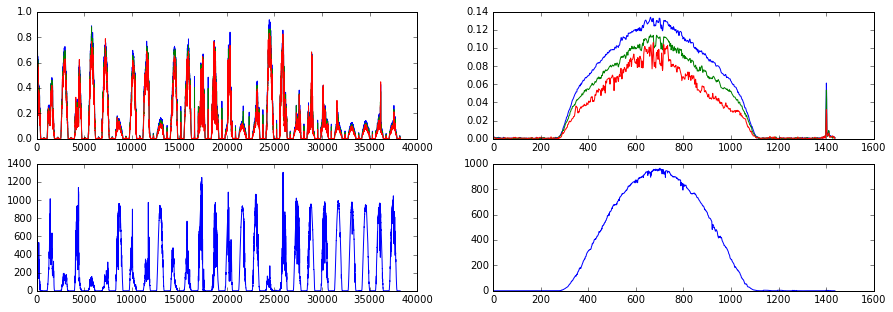

In [699]:

 
fig=plt.figure(figsize=(15, 5))

plt.subplot(2,2,1)
[plt.plot(d) for d in train_data_A[0:3]]
plt.subplot(2,2,2)
[plt.plot(d) for d in test_data_A[0:3]]

plt.subplot(2,2,3)
plt.plot(train_label_A)

plt.subplot(2,2,4)
plt.plot(estimated_A[0])
#plt.plot(true_data)
plt.savefig("trainingdata_and_result_A.png", dpi=250)

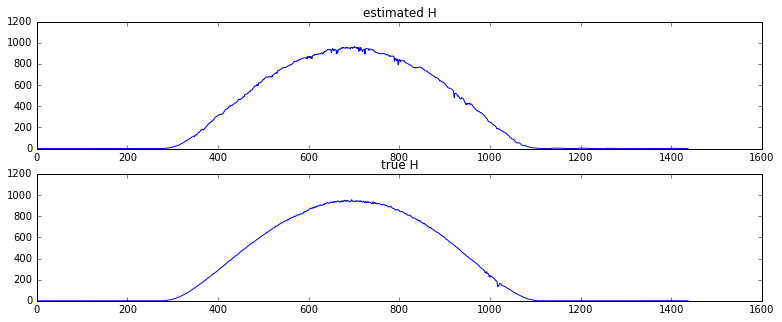

In [700]:

 
plt.figure(figsize=(13, 5))
plt.subplot(2,1,1)
plt.title("estimated H")
plt.ylim(0,1200)
plt.plot(estimated_A[0], lw=1)

plt.subplot(2,1,2)
plt.title("true H")
plt.ylim(0,1200)
plt.plot(true_data_A, lw=1)

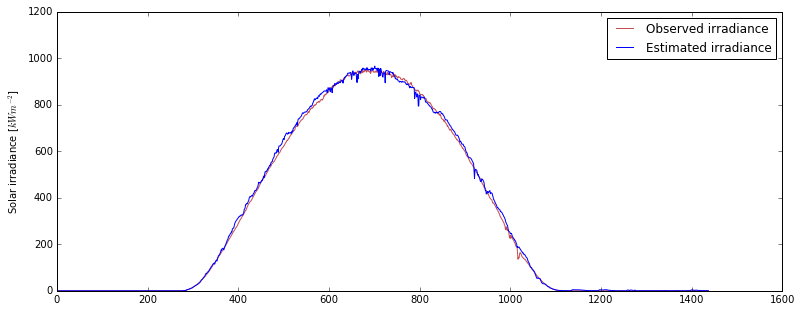

In [701]:
 
plt.figure(figsize=(13, 5))
plt.title("")
plt.ylim(0,1200)
plt.plot(true_data_A,  label="Observed irradiance", color='#c44e52',lw=1)
plt.plot(estimated_A[0],  label="Estimated irradiance", lw=1)
plt.legend()
plt.ylabel(r'Solar irradiance [$kWm^{-2}$]')

plt.savefig("RFestimate_and_observed.png", dpi=250)

RMSE:
    MAX: 11.6659592182
    MIN: 11.6659592182
   MEAN: 11.6659592182
Coeff:
    MAX: 0.999572610983
    MIN: 0.999572610983
   MEAN: 0.999572610983


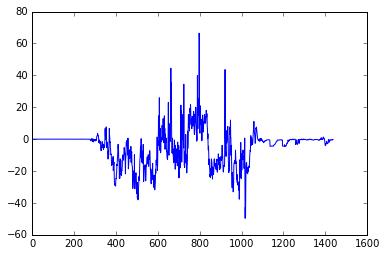

In [702]:
 
RMSE_A = [];
Coef_A = [];
for i in range(len(estimated_A)):
    error_A = true_data_A - estimated_A[i]
    plt.plot(error_A,lw=1)
    RMSE_A.append(np.sqrt(np.mean((error_A)*(error_A))))
    std_A = np.std(error_A)
    Coef_A.append(np.corrcoef(true_data_A, estimated_A[i])[1][0])
    
print('RMSE:')
print('    MAX:', max(RMSE_A))
print('    MIN:', min(RMSE_A))
print('   MEAN:', np.mean(RMSE_A))
print('Coeff:')
print('    MAX:', max(Coef_A))
print('    MIN:', min(Coef_A))
print('   MEAN:', np.mean(Coef_A))

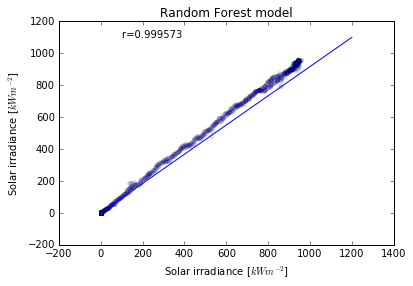

In [703]:

t_est_A = np.array([1,1200]); t_true_A = np.array([1,1100]);
plt.scatter(true_data_A, estimated_A[0], alpha=0.1, s=15)
plt.plot(t_est_A,t_true_A);
plt.ylabel(r'Solar irradiance [$kWm^{-2}$]')
plt.xlabel(r'Solar irradiance [$kWm^{-2}$]')
plt.title('Random Forest model')
plt.text(100,1100,r'r=%f '%(np.corrcoef((true_data_A, estimated_A[0]))[0,1]) )
np.correlate(t_est_A,t_true_A)
plt.savefig("RFaccuracy", dpi=250)


##### パターンB

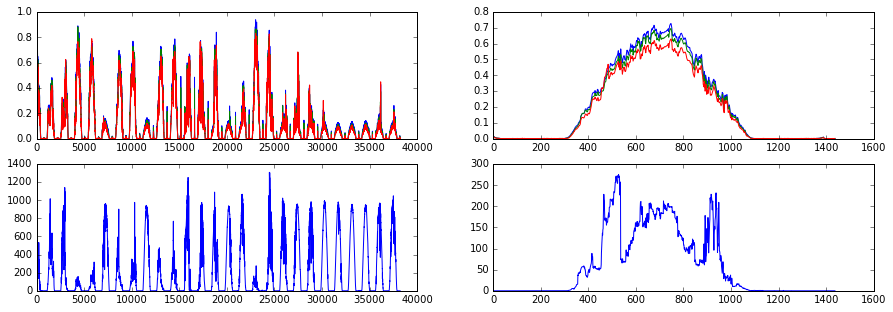

In [704]:
fig=plt.figure(figsize=(15, 5))

plt.subplot(2,2,1)
[plt.plot(d) for d in train_data_B[0:3]]
plt.subplot(2,2,2)
[plt.plot(d) for d in test_data_B[0:3]]

plt.subplot(2,2,3)
plt.plot(train_label_B)

plt.subplot(2,2,4)
plt.plot(estimated_B[0])
plt.savefig("trainingdata_and_result_B.png", dpi=250)


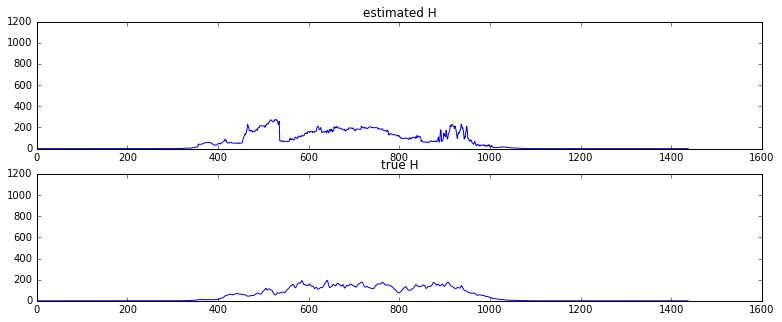

In [705]:
 
plt.figure(figsize=(13, 5))
plt.subplot(2,1,1)
plt.title("estimated H")
plt.ylim(0,1200)
plt.plot(estimated_B[0], lw=1)

plt.subplot(2,1,2)
plt.title("true H")
plt.ylim(0,1200)
plt.plot(true_data_B, lw=1)

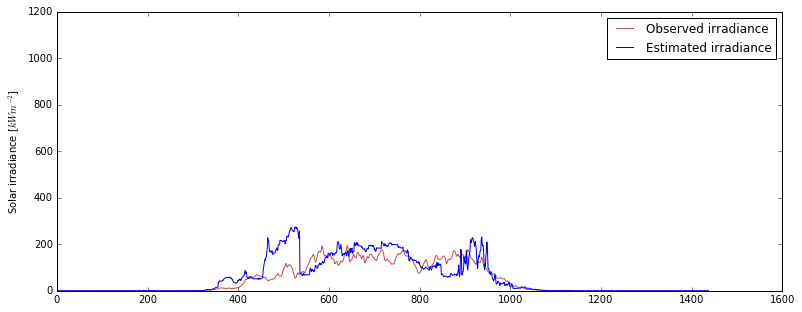

In [706]:
plt.figure(figsize=(13, 5))
plt.title("")
plt.ylim(0,1200)
plt.plot(true_data_B,  label="Observed irradiance", color='#c44e52',lw=1)
plt.plot(estimated_B[0],  label="Estimated irradiance", lw=1)
plt.legend()
plt.ylabel(r'Solar irradiance [$kWm^{-2}$]')

plt.savefig("RFestimate_and_observed_B.png", dpi=250)

RMSE:
    MAX: 43.4959240451
    MIN: 43.4959240451
   MEAN: 43.4959240451
Coeff:
    MAX: 0.83641004841
    MIN: 0.83641004841
   MEAN: 0.83641004841


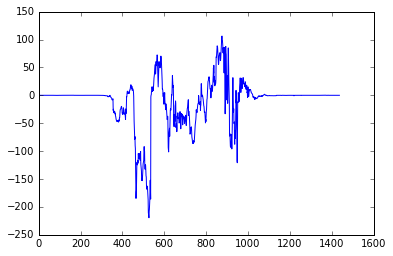

In [707]:
 
RMSE_B = [];
Coef_B = [];
for i in range(len(estimated_B)):
    error_B = true_data_B - estimated_B[i]
    plt.plot(error_B,lw=1)
    RMSE_B.append(np.sqrt(np.mean((error_B)*(error_B))))
    std_B = np.std(error_B)
    Coef_B.append(np.corrcoef(true_data_B, estimated_B[i])[1][0])
    
print('RMSE:')
print('    MAX:', max(RMSE_B))
print('    MIN:', min(RMSE_B))
print('   MEAN:', np.mean(RMSE_B))
print('Coeff:')
print('    MAX:', max(Coef_B))
print('    MIN:', min(Coef_B))
print('   MEAN:', np.mean(Coef_B))
 

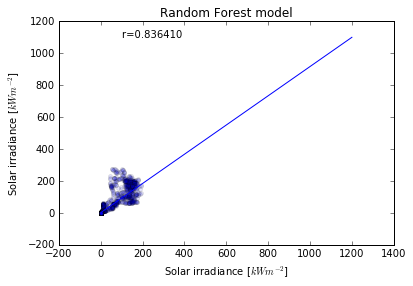

In [708]:

t_est_B = np.array([1,1200]); t_true_B = np.array([1,1100]);
plt.scatter(true_data_B, estimated_B[0], alpha=0.1, s=15)
plt.plot(t_est_B,t_true_B);
plt.ylabel(r'Solar irradiance [$kWm^{-2}$]')
plt.xlabel(r'Solar irradiance [$kWm^{-2}$]')
plt.title('Random Forest model')
plt.text(100,1100,r'r=%f '%(np.corrcoef((true_data_B, estimated_B[0]))[0,1]) )
np.correlate(t_est_B,t_true_B)
plt.savefig("RFaccuracy", dpi=250)


##### パターンC

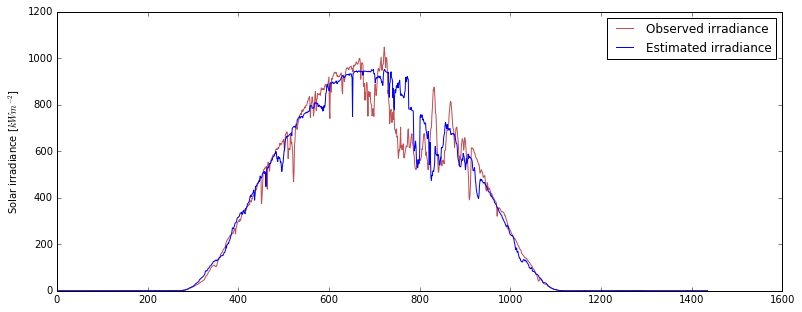

In [710]:
plt.figure(figsize=(13, 5))
plt.title("")
plt.ylim(0,1200)
plt.plot(true_data_C,  label="Observed irradiance", color='#c44e52',lw=1)
plt.plot(estimated_C[0],  label="Estimated irradiance", lw=1)
plt.legend()
plt.ylabel(r'Solar irradiance [$kWm^{-2}$]')

plt.savefig("RFestimate_and_observed_B.png", dpi=250)

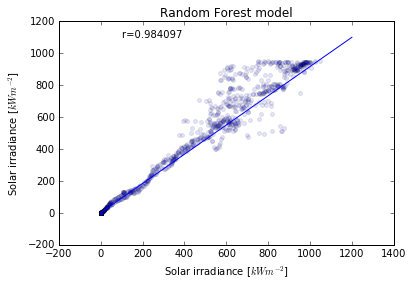

In [711]:
t_est_C = np.array([1,1200]); t_true_C = np.array([1,1100]);
plt.scatter(true_data_C, estimated_C[0], alpha=0.1, s=15)
plt.plot(t_est_C,t_true_C);
plt.ylabel(r'Solar irradiance [$kWm^{-2}$]')
plt.xlabel(r'Solar irradiance [$kWm^{-2}$]')
plt.title('Random Forest model')
plt.text(100,1100,r'r=%f '%(np.corrcoef((true_data_C, estimated_C[0]))[0,1]) )
np.correlate(t_est_C,t_true_C)
plt.savefig("RFaccuracy", dpi=250)

##### パターンD

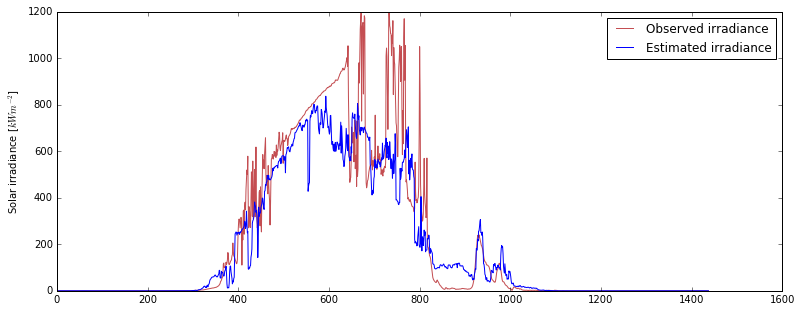

In [712]:
plt.figure(figsize=(13, 5))
plt.title("")
plt.ylim(0,1200)
plt.plot(true_data_D,  label="Observed irradiance", color='#c44e52',lw=1)
plt.plot(estimated_D[0],  label="Estimated irradiance", lw=1)
plt.legend()
plt.ylabel(r'Solar irradiance [$kWm^{-2}$]')

plt.savefig("RFestimate_and_observed_B.png", dpi=250)

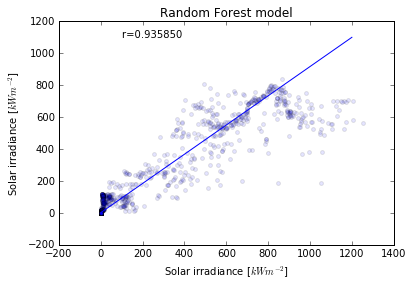

In [713]:
t_est_D = np.array([1,1200]); t_true_D = np.array([1,1100]);
plt.scatter(true_data_D, estimated_D[0], alpha=0.1, s=15)
plt.plot(t_est_D,t_true_D);
plt.ylabel(r'Solar irradiance [$kWm^{-2}$]')
plt.xlabel(r'Solar irradiance [$kWm^{-2}$]')
plt.title('Random Forest model')
plt.text(100,1100,r'r=%f '%(np.corrcoef((true_data_D, estimated_D[0]))[0,1]) )
np.correlate(t_est_D,t_true_D)
plt.savefig("RFaccuracy", dpi=250)